If you enjoy Oban, then you may also enjoy OldPulteney, Clynelish, Talisker.


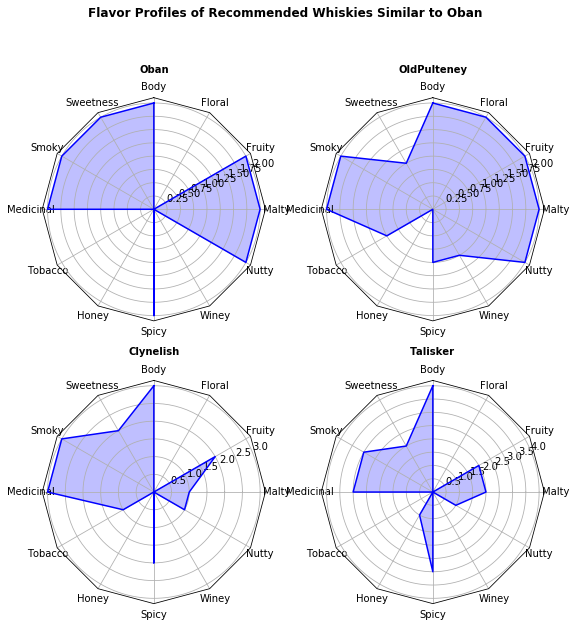

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-9.0,54.0,2.5,59.5&bboxSR=4326&imageSR=4326&size=1500,717&dpi=96&format=png32&f=image


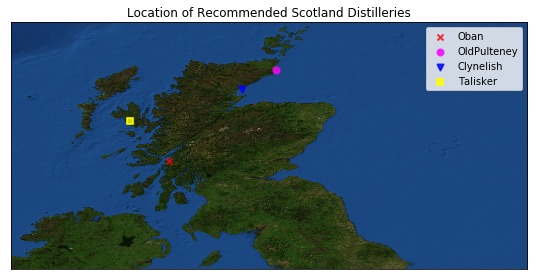

In [6]:
#Enter the name of a single malt scotch whiskey you enjoy, then run the cell to get some recommendations.
scotch='Oban'


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
#from mpl_toolkits.basemap import Basemap

# Importing whiskey dataset
whiskey=pd.read_csv('whiskies.txt')
whiskey.loc[:,'Region']=pd.read_csv('regions.txt')
whiskey=whiskey.drop('RowID',axis=1)
whiskey=whiskey.set_index('Distillery')
flavors=whiskey.iloc[:,:12]

# Applying Hierarchical Clustering with complete linkage
mergings=linkage(whiskey.iloc[:,:12],method='complete')
labels = fcluster(mergings,6,criterion='distance')
df_hc = pd.DataFrame({'Group': labels, 'Region': whiskey['Region']})

# Applying K-Means clustering with 4 clusters
model_km=KMeans(n_clusters=4, random_state=412)
model_km.fit(whiskey.iloc[:,:12])
Whiskey_Clusters=model_km.predict(whiskey.iloc[:,:12])
df_km=whiskey[['Region']]
df_km.loc[:,'Group']=Whiskey_Clusters

# Applying Spectral Clustering with 4 clusters
model_sc = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans',random_state=42)
labels = model_sc.fit_predict(whiskey.iloc[:,:12])
df_sc=whiskey[['Region']]
df_sc.loc[:,'Group']=labels

# Forming the intersection of groups from K-Means and Hierarchical Clustering
df_hc.loc[:,'Group']=df_hc['Group'].replace([1,2,3,4],[2,0,1,3])
common_groups=df_hc.loc[df_hc['Group']==df_km['Group'],:]

# Forming intersection of groups from all 3 clustering methods
df_sc.loc[:,'Group']=df_sc['Group'].replace([0,1,2,3],[0,3,1,2])
index_cg=common_groups.index
df_sc_a=df_sc.loc[index_cg]
common_groups=common_groups.loc[common_groups['Group']==df_sc_a['Group'],:]

# Applying Non-negative Matrix Factorization with 6 components to generate final recommendations
nmf = NMF(n_components=6)
normalizer = Normalizer()
pipeline = make_pipeline(nmf,normalizer)
norm_features = pipeline.fit_transform(whiskey.iloc[:,:12])
df_nmf = pd.DataFrame(norm_features,index=whiskey.index)
distillery = df_nmf.loc[scotch]
similarities = df_nmf.dot(distillery)
top_sim=similarities.nlargest()
top_5=top_sim.index
top_4=list(top_5[1:])
print('If you enjoy '+scotch+', then you may also enjoy '+top_4[0]+', '+top_4[1]+', '+top_4[2]+'.')


# The following code produces a radar plot of the flavors for the scotch and the recommended selections.
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

whiskies=list(top_5)
data = [
        list(flavors.columns),
        (whiskies[0], [
            list(flavors.loc[whiskies[0]].values),
            ]),
        (whiskies[1], [
            list(flavors.loc[whiskies[1]].values),
            ]),
        (whiskies[2], [
            list(flavors.loc[whiskies[2]].values),
            ]),
        (whiskies[3], [
            list(flavors.loc[whiskies[3]].values),
            ]),
        (whiskies[3], [
            list(flavors.loc[whiskies[3]].values),
            ]),
    ]



if __name__ == '__main__':
    N = 12
    theta = radar_factory(N, frame='polygon')

    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    ax = axes[0, 0]

    fig.text(0.5, 0.965, 'Flavor Profiles of Recommended Whiskies Similar to ' + scotch,
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()
    
# Code that plots the geographical location of the recommended distilleries.

# Converting coordinates from British National Grid (BNG) to Latitude, Longitude.
from convertbng.util import convert_lonlat

lat=list(whiskey.iloc[:,-3])
lon=list(whiskey.iloc[:,-2])

coordinates=convert_lonlat(lat,lon)

whiskey.loc[:,'longitude']=coordinates[0]
whiskey.loc[:,'latitude']=coordinates[1]

from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
m1 = Basemap(llcrnrlon=-9.,llcrnrlat=54,urcrnrlon=2.5,urcrnrlat=59.5,
            resolution='h')

m1.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
colors1=['red','magenta','blue','yellow']
markers1=['x','o','v','s']
for color, marker, i in zip(colors1, markers1, [0, 1, 2, 3]):
    m1.scatter(whiskey.loc[whiskies[i],'longitude'], whiskey.loc[whiskies[i],'latitude'], marker=marker, color=color, alpha=.8, lw=2, label=whiskies[i])
plt.title("Location of Recommended Scotland Distilleries")
plt.legend()

plt.show()

